In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [3]:
class ModelManager:
    def __init__(self, model, feature_scaler, target_scaler, seq_length, features):
        self.model = model
        self.feature_scaler = feature_scaler
        self.target_scaler = target_scaler
        self.seq_length = seq_length
        self.features = features

    def save(self, path):
        """Save model, scalers, and configuration"""
        save_dict = {
            'model_state': self.model.state_dict(),
            'feature_scaler': self.feature_scaler,
            'target_scaler': self.target_scaler,
            'seq_length': self.seq_length,
            'features': self.features,
            'model_config': {
                'input_size': len(self.features),
                'hidden_size': self.model.lstm1.hidden_size,
                'num_layers': self.model.lstm1.num_layers,
                'dropout': self.model.dropout1.p
            }
        }
        torch.save(save_dict, path)

    @classmethod
    def load(cls, path, device='cuda'):
        """Load saved model and configuration"""
        save_dict = torch.load(path, map_location=device)
        model = TECPredictor(**save_dict['model_config']).to(device)
        model.load_state_dict(save_dict['model_state'])
        return cls(model, save_dict['feature_scaler'], save_dict['target_scaler'],
                   save_dict['seq_length'], save_dict['features'])

    def predict(self, input_data):
        """Make predictions using saved model"""
        self.model.eval()
        with torch.no_grad():
            scaled_input = self.feature_scaler.transform(input_data[self.features])
            input_tensor = torch.FloatTensor(scaled_input).unsqueeze(0).to(next(self.model.parameters()).device)
            output = self.model(input_tensor)
            return self.target_scaler.inverse_transform(output.cpu().numpy())

In [4]:
class TECDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class TECPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, dropout=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=2,
                           dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)

        # Attention mechanism
        self.attention = nn.Linear(hidden_size * 2, 1)

        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=1,
                           batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, 1)

        self.layer_norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x):
        # Bidirectional LSTM
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)
        lstm_out = self.layer_norm(lstm_out)

        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        lstm_out = lstm_out * attention_weights

        # Second LSTM layer
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])

        # Dense layers
        out = self.fc1(lstm_out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

In [5]:
def create_sequences(data, seq_length, features, target='TEC'):
    if len(data) < seq_length:
        raise ValueError("Data length is smaller than the sequence length.")
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:(i + seq_length)].values)
        y.append(data[target].iloc[i + seq_length])
    return np.array(X), np.array(y)

In [6]:
def train_model_with_checkpoints(model, train_loader, val_loader, criterion, optimizer,
                                 scheduler, num_epochs, device, checkpoint_path='checkpoint.pth'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    start_epoch = 0

    if os.path.exists(checkpoint_path):
        print(f"Resuming training from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        best_val_loss = checkpoint['best_val_loss']

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y.unsqueeze(1)).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # torch.save(model.state_dict(), 'last_model.pth')
        checkpoint = {
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss,
        }
        torch.save(checkpoint, checkpoint_path)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

In [7]:
def predict_and_evaluate(model, data_loader, target_scaler, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.numpy())

    # Ensure predictions and actuals are reshaped to 2D
    predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = target_scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    # Flatten the reshaped arrays for evaluation metrics
    predictions = predictions.flatten()
    actuals = actuals.flatten()

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mape = mean_absolute_percentage_error(actuals, predictions)

    return predictions, actuals, rmse, mape

In [8]:
def plot_training_history(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(actual, predicted, dates=None):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(12, 6))
    if dates is not None:
        plt.plot(dates, actual, label='Actual', alpha=0.7)
        plt.plot(dates, predicted, label='Predicted', alpha=0.7)
        plt.xlabel('Date')
    else:
        plt.plot(actual, label='Actual', alpha=0.7)
        plt.plot(predicted, label='Predicted', alpha=0.7)
        plt.xlabel('Time Step')
    plt.ylabel('TEC Value')
    plt.title('TEC Predictions vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions_with_peaks(actual, predicted, dates=None, distance=2):
    """Plot actual vs predicted values with peak points marked"""
    plt.figure(figsize=(12, 6))

    # Use indices as x-axis if dates are not provided
    x_axis = dates if dates is not None else range(len(actual))

    plt.plot(x_axis, actual, label='Actual', alpha=0.7, color='blue')
    plt.plot(x_axis, predicted, label='Predicted', alpha=0.7, color='orange')

    # Find peak indices
    actual_peaks = find_peaks(actual, distance=distance)[0]
    predicted_peaks = find_peaks(predicted, distance=distance)[0]

    # Plot peak points
    plt.scatter(np.array(x_axis)[actual_peaks], np.array(actual)[actual_peaks], color='red', label='Actual Peaks')
    plt.scatter(np.array(x_axis)[predicted_peaks], np.array(predicted)[predicted_peaks], color='green', label='Predicted Peaks')

    plt.xlabel('Date' if dates is not None else 'Time Step')
    plt.ylabel('TEC Value')
    plt.title('TEC Predictions vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_residuals(actual, predicted):
    """Plot residual analysis"""
    residuals = actual - predicted.reshape(-1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Residuals over time
    ax1.scatter(range(len(residuals)), residuals, alpha=0.5)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_title('Residuals Over Time')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Residual')
    ax1.grid(True)

    # Residual distribution
    ax2.hist(residuals, bins=50, density=True, alpha=0.7)
    ax2.set_title('Residual Distribution')
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Density')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_error_distribution(actual, predicted):
    """Plot error distribution analysis"""
    plt.figure(figsize=(10, 6))

    percentage_errors = np.abs((actual - predicted.reshape(-1)) / actual * 100)

    plt.hist(percentage_errors, bins=50, density=True, alpha=0.7)
    plt.axvline(np.median(percentage_errors), color='r', linestyle='--',
                label=f'Median Error: {np.median(percentage_errors):.2f}%')
    plt.title('Percentage Error Distribution')
    plt.xlabel('Absolute Percentage Error')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_results(train_losses, val_losses, actual, predicted, dates=None):
    """Generate all visualizations"""
    plot_training_history(train_losses, val_losses)
    plot_predictions(actual, predicted, dates)
    plot_predictions_with_peaks(actual, predicted,dates)
    plot_residuals(actual, predicted)
    plot_error_distribution(actual, predicted)


In [13]:
def main(df, train_end_date, seq_length=24, batch_size=32, checkpoint_path='/content/drive/MyDrive/earth_quake/checkpoint.pth', output_path='/content/drive/MyDrive/earth_quake/processed_data.xlsx'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Feature engineering
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['day']/365)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/365)

    features = ['Ap', 'Kp', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

    # Separate scalers for features and target
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    df[features] = feature_scaler.fit_transform(df[features])
    df['TEC'] = target_scaler.fit_transform(df[['TEC']])

    # # Save the processed DataFrame to a file
    # df.to_excel(output_path, index=False)  # Save as Excel
    # print(f"Processed data saved to {output_path}")

    # Split data
    train = df[df['year'] <= train_end_date].copy()
    val_size = int(0.2 * len(train))
    train, val = train[:-val_size], train[-val_size:]
    test = df[df['year'] > train_end_date].copy()

    # Create sequences
    X_train, y_train = create_sequences(train, seq_length, features)
    X_val, y_val = create_sequences(val, seq_length, features)
    X_test, y_test = create_sequences(test, seq_length, features)

    # Create dataloaders
    train_dataset = TECDataset(X_train, y_train)
    val_dataset = TECDataset(X_val, y_val)
    test_dataset = TECDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    model = TECPredictor(input_size=len(features)).to(device)

    # Load the model state from the checkpoint if it exists
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        print(f"Model loaded from checkpoint: {checkpoint_path}")

    # Training setup
    criterion = nn.HuberLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Train model
    train_losses, val_losses = train_model_with_checkpoints(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        num_epochs=24, device=device, checkpoint_path=checkpoint_path
    )

    model.load_state_dict(torch.load('/content/drive/MyDrive/earth_quake/best_model1.pth'))
    test_pred, test_actual, test_rmse, test_mape = predict_and_evaluate(
        model, test_loader, target_scaler, device
    )

    # Add predictions to the original DataFrame
    test_indices = df[df['year'] > train_end_date].index[seq_length:]
    df.loc[test_indices, 'Predicted_TEC'] = test_pred

    # Save the updated DataFrame to a file
    output='/content/drive/MyDrive/earth_quake/finaldata.xlsx'
    df.to_excel(output, index=False)
    print(f"Updated data with predictions saved to {output_path}")

    # Visualizations
    print(train_losses)
    print(val_losses)
    print(test_actual)
    print(test_pred)
    visualize_results(train_losses, val_losses, test_actual, test_pred)

    return model, test_pred, test_actual, test_rmse, test_mape, train_losses, val_losses


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
! pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.0 MB/s eta 0:00:00


Loading checkpoint from: /content/drive/MyDrive/earth_quake/checkpoint.pth
Model loaded from checkpoint: /content/drive/MyDrive/earth_quake/checkpoint.pth
Resuming training from checkpoint: /content/drive/MyDrive/earth_quake/checkpoint.pth


<ipython-input-13-35a4a0eb5047>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.11/dis

Updated data with predictions saved to /content/drive/MyDrive/earth_quake/processed_data.xlsx
[0.002230183069672574, 0.0013934166705043256, 0.0013022079537141173, 0.001271419948871677, 0.0012380375684951587, 0.0012422392885931219, 0.0011796463847311308, 0.0011437601950238304, 0.001138567844098519, 0.0011119249154592148, 0.0011060620529458063, 0.0010870044655485512, 0.0010838620996482997, 0.00106053445620729, 0.0009848049314648876, 0.000971413148626769, 0.0009700207869581202, 0.000946995171745106, 0.0009461293059254043, 0.0009327025398464244, 0.0008818238245224427, 0.0008691581558272582, 0.000864499020176063, 0.0008484814510249702]
[0.0019898814076897277, 0.0017811449736040012, 0.00189935397388664, 0.002465823144279907, 0.0017371950814886173, 0.001791223821431756, 0.0019416797738376391, 0.0017275488032280364, 0.0018733390887719567, 0.001992332343400855, 0.0017572893069521464, 0.002103827118227081, 0.0019049165991463822, 0.001881006321056403, 0.002167076885508125, 0.0018369920862230408, 

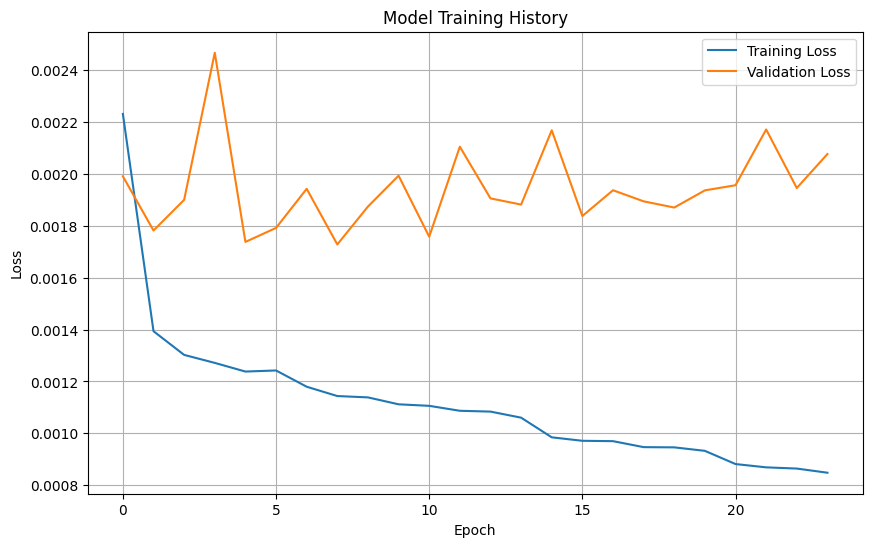

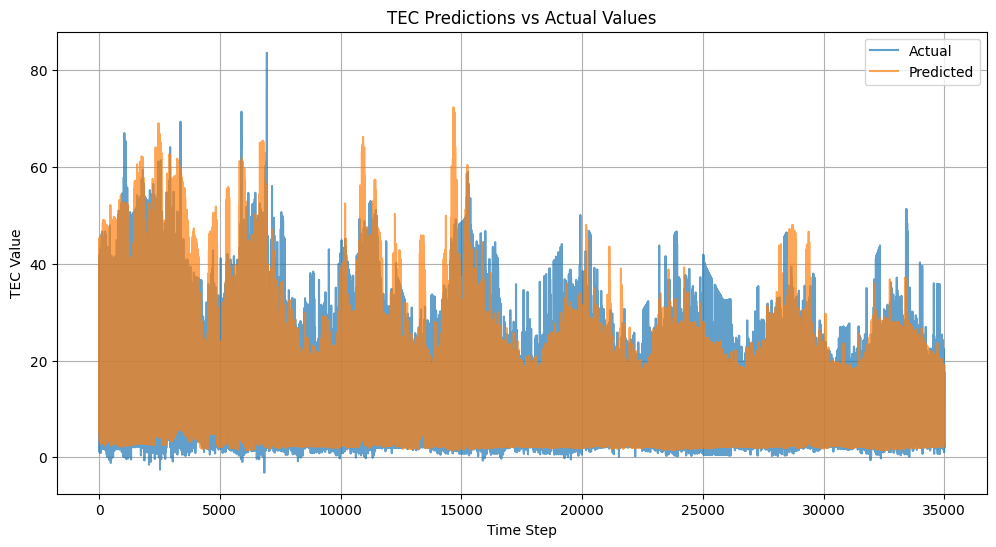

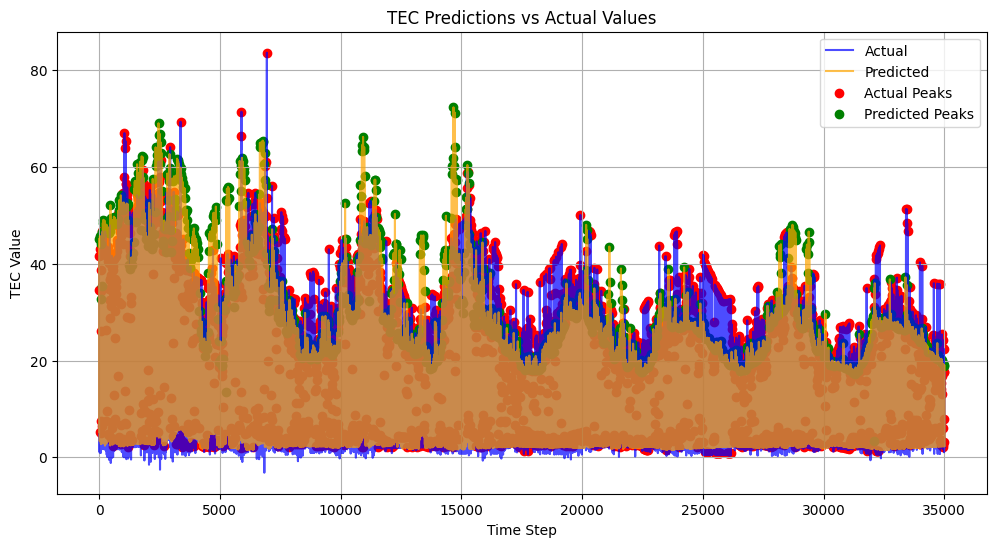

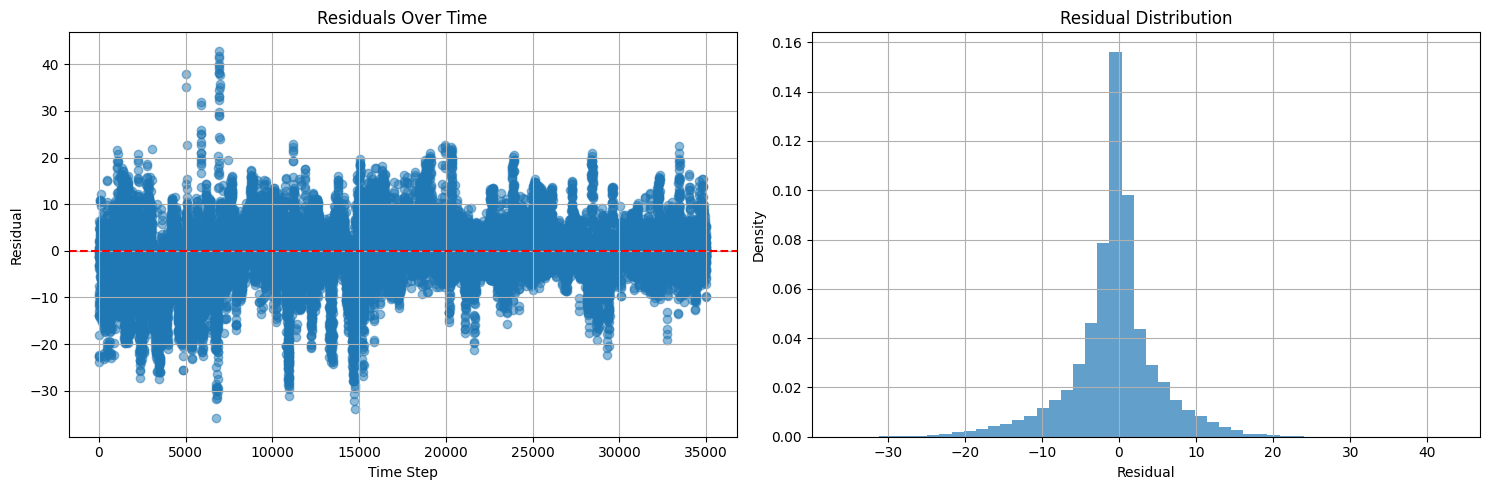

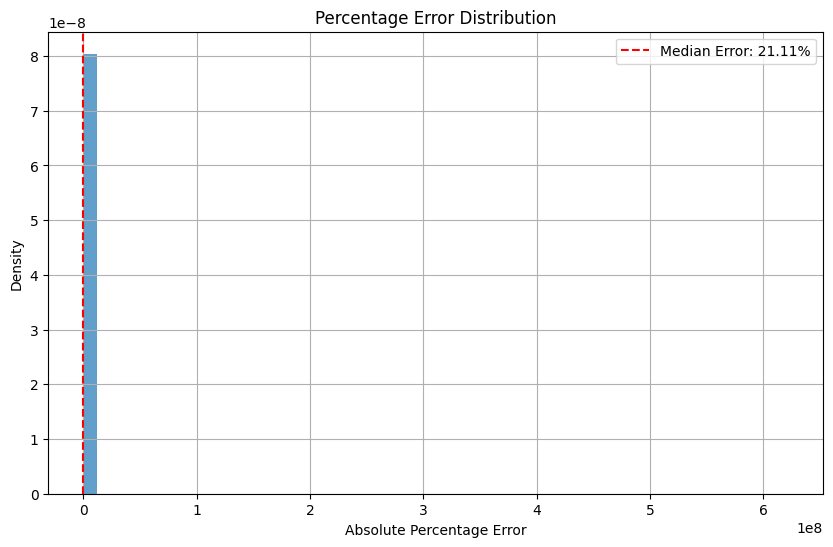

In [15]:
df = pd.read_excel("/content/drive/MyDrive/earth_quake/DATAHyd.xlsx", header=None)
df.columns = ['year', 'day', 'hour', 'Ap', 'Kp', 'TEC']
manager, predictions, actuals, rmse, mape, train_losses, val_losses = main(df, train_end_date=2015)